# **ALGORITMO DE CLUSTERING CON DIANA**

# Consideraciones iniciales




1.   No se utilizó clustering con DIANA puro, debido a que las implementaciónes existentes en python venían con las librerias "pycluster" y "sklearn-extra", librerías incompatibles con el entorno de ejecución actual (en el caso de "pycluster" un método no fue compatible, no la librería en sí).
2.   Debe haber un prebio filtrado de los datos usando PCA.
3.   Se utiliza el algoritmo de clustering "Agglomerative Clustering" de sklearn.
4.   Se sigue un pipeline personalizado, con la motivación de que; una vez hecho el clustering, se pueda aplicar cualquier algoritmo de clasificación, donde la variable Y es el cluster (agarrar datos y sacar columna target en datos Y que será el cluster) para medir resultados con el método de la silueta.





# Visualización de los datos preliminares del PCA
Este código realiza un Análisis de Componentes Principales (PCA) sobre un conjunto de datos para entender la variabilidad presente y reducir potencialmente la dimensionalidad.

De esta manera, se quiere ver la importancia de cada componente PCA, que servirá como guía en caso de que sea prodente obviar alguna cantidad de componentes.

El archivo es cargado en X = pd.read_csv.

La tabla resultante es:

**Component | Standard Deviation | Proportion of Variance | Cumulative Variance**

In [4]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = pd.read_csv("TrainX_eng_cls.csv") #nombre del aechivo

# estandaización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


pca = PCA()
pca.fit(X_scaled)

# desviaciones estándar y varianzas
std_dev = (pca.explained_variance_) ** 0.5
prop_var = pca.explained_variance_ratio_
cum_var = prop_var.cumsum()


pca_summary = pd.DataFrame({
    'Component': [f'PC {i+1}' for i in range(len(prop_var))],
    'Standard Deviation': std_dev.round(4),
    'Proportion of Variance': prop_var.round(4),
    'Cumulative Variance': cum_var.round(4)
})


print(pca_summary)


#pca_summary.to_csv("PCA_summary_eng_cls.csv", index=False)


   Component  Standard Deviation  Proportion of Variance  Cumulative Variance
0       PC 1              1.0104                  0.0785               0.0785
1       PC 2              1.0098                  0.0784               0.1570
2       PC 3              1.0079                  0.0781               0.2351
3       PC 4              1.0048                  0.0777               0.3128
4       PC 5              1.0041                  0.0775               0.3903
5       PC 6              1.0023                  0.0773               0.4676
6       PC 7              0.9993                  0.0768               0.5444
7       PC 8              0.9975                  0.0765               0.6209
8       PC 9              0.9957                  0.0763               0.6972
9      PC 10              0.9951                  0.0762               0.7734
10     PC 11              0.9925                  0.0758               0.8491
11     PC 12              0.9911                  0.0756        

# **Sacar Clusters**
Este código realiza un proceso de segmentación de clientes (o de datos) utilizando una combinación de Análisis de Componentes Principales (PCA) para la reducción de dimensionalidad y Clustering Jerárquico Aglomerativo para la agrupación.

El objetivo es identificar grupos naturales (clusters) en el conjunto de datos de entrenamiento y guardar el resultado junto con las nuevas coordenadas de PCA.

Añade los clusters a una nueva columna del PCA

**Linkage Methods:**

*   ward: Minimiza la suma de las variaciones (varianza) dentro de todos los clusters que se forman. Tiende a producir clusters de tamaño y forma similar.
*   complete: Mide la distancia más grande entre cualquier punto de datos en el primer cluster y cualquier punto de datos en el segundo.
*   average: Mide la distancia promedio (media) entre todos los puntos del primer cluster y todos los puntos del segundo.
*   single: Mide la distancia más corta entre cualquier punto de datos en el primer cluster y cualquier punto de datos en el segundo.

**Métricas de Distancia**
* euclidean: Distancia de la línea recta.
* manhattan: Distancia del Bloque de la Ciudad o L1. Es la suma de las diferencias absolutas de las coordenadas.
* cosine: Mide el ángulo entre dos vectores, no la magnitud.

**Método de la silueta**
Es una métrica utilizada para validar la consistencia y calidad de los clústeres dentro de un conjunto de datos. Proporciona una medida de cuán similar es un objeto a su propio clúster en comparación con otros clústeres.

El Silhouette Score general que usa el código es el promedio de los coeficientes de silueta $s(i)$ para todas las muestras del conjunto de datos. El número de clústeres óptimo ($best\_k$) es aquel que maximiza este valor promedio.

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


n_components_pca = 12        # Número de componentes principales
linkage_method = 'ward'      # Método de enlace (ward no usa métrica de distancia explícita)
distance_metric = 'euclidean'

X = pd.read_csv("TrainX_eng_cls.csv")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


pca = PCA(n_components=n_components_pca)
X_pca = pca.fit_transform(X_scaled)

print(f"Usando {n_components_pca} componentes principales.")
print(f"Varianza explicada acumulada: {pca.explained_variance_ratio_.sum():.3f}")


#Cálculo del método de silueta

range_clusters = range(2, 11)
silhouette_scores = []

for k in range_clusters:
    if linkage_method == 'ward':
        model = AgglomerativeClustering(n_clusters=k, linkage=linkage_method)
    else:
        model = AgglomerativeClustering(n_clusters=k, linkage=linkage_method, metric=distance_metric)

    labels = model.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)
    print(f"Clusters: {k}, Silhouette Score: {score:.4f}")

# determinar mejor numero de clusters
best_k = range_clusters[silhouette_scores.index(max(silhouette_scores))]
best_score = max(silhouette_scores)
print(f"\n Mejor número de clusters según el método de silueta: {best_k} (Score = {best_score:.4f})")



#  Clustering final con el número óptimo de clusters

if linkage_method == 'ward':
    model = AgglomerativeClustering(n_clusters=best_k, linkage=linkage_method)
else:
    model = AgglomerativeClustering(n_clusters=best_k, linkage=linkage_method, metric=distance_metric)

labels = model.fit_predict(X_pca)


X_clustered = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
X_clustered['Cluster'] = labels

X_out = pd.concat(
    [pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components_pca)]),
     pd.Series(labels, name='Cluster')],
    axis=1
)

X_out.to_csv("TrainX_eng_cls_clustered.csv", index=False)
print("\nArchivo guardado: TrainX_eng_cls_clustered.csv")


Usando 12 componentes principales.
Varianza explicada acumulada: 0.925
Clusters: 2, Silhouette Score: 0.0919
Clusters: 3, Silhouette Score: 0.1296
Clusters: 4, Silhouette Score: 0.1697
Clusters: 5, Silhouette Score: 0.1649
Clusters: 6, Silhouette Score: 0.1565
Clusters: 7, Silhouette Score: 0.1440
Clusters: 8, Silhouette Score: 0.1404
Clusters: 9, Silhouette Score: 0.1379
Clusters: 10, Silhouette Score: 0.1315

✅ Mejor número de clusters según el método de silueta: 4 (Score = 0.1697)

Archivo guardado: TrainX_eng_cls_clustered.csv


Un mayor coheficiente de silueta indica un mejor desempeño
en este caso el mejor silhouette score fue n = 4 clusters

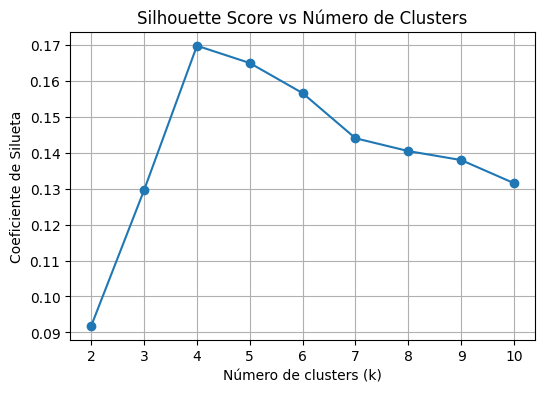

In [6]:

plt.figure(figsize=(6,4))
plt.plot(range_clusters, silhouette_scores, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Coeficiente de Silueta")
plt.title("Silhouette Score vs Número de Clusters")
plt.grid(True)
plt.show()


# Visualización de los clusters

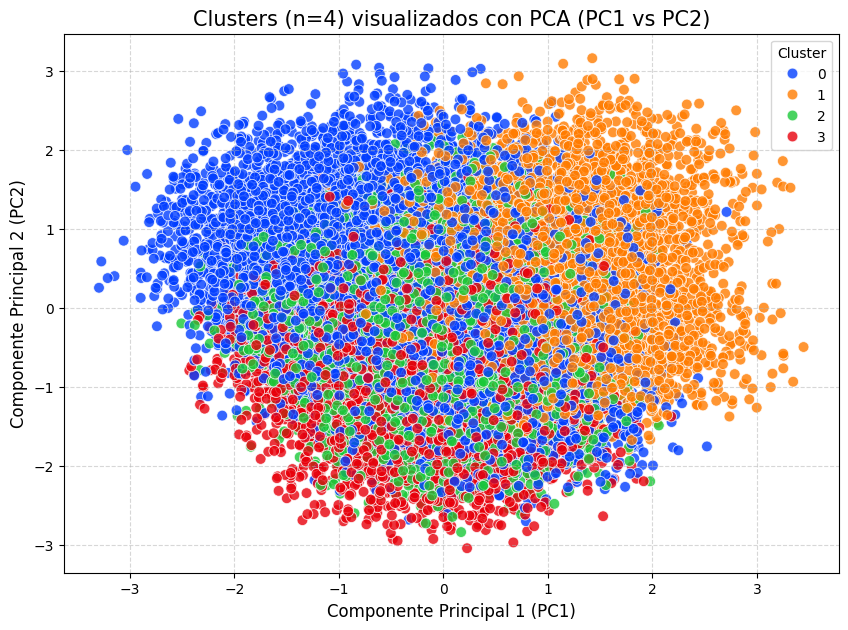

In [8]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=X_clustered,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='bright',
    s=60,
    alpha=0.8
)

plt.title(f'Clusters (n={best_k}) visualizados con PCA (PC1 vs PC2)', fontsize=15)
plt.xlabel('Componente Principal 1 (PC1)', fontsize=12)
plt.ylabel('Componente Principal 2 (PC2)', fontsize=12)
plt.legend(title='Cluster', loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Visualización de los clusters en forma de dendograma

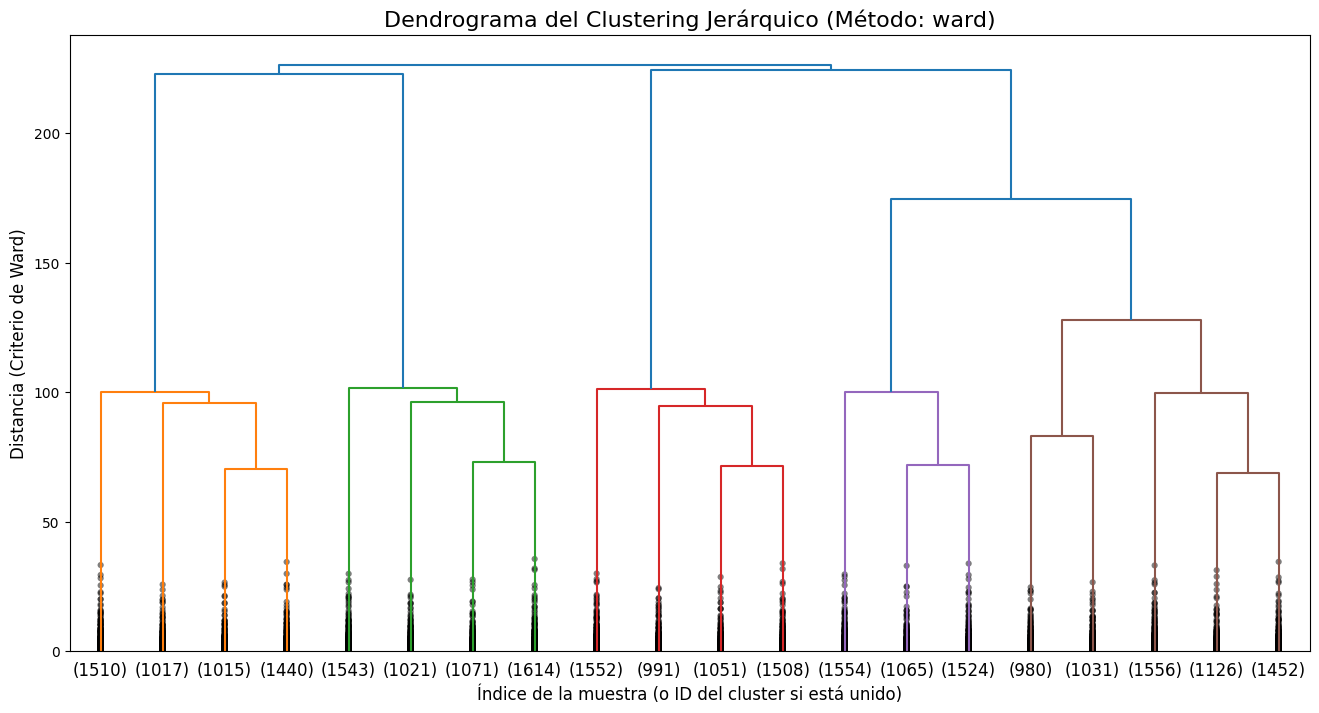

In [9]:
from scipy.cluster import hierarchy


Z = hierarchy.linkage(X_pca, method=linkage_method)


plt.figure(figsize=(16, 8))
plt.title(f'Dendrograma del Clustering Jerárquico (Método: {linkage_method})', fontsize=16)
plt.xlabel('Índice de la muestra (o ID del cluster si está unido)', fontsize=12)
plt.ylabel('Distancia (Criterio de Ward)', fontsize=12)

hierarchy.dendrogram(
    Z,
    truncate_mode='lastp',
    p=20,
    show_leaf_counts=True,
    show_contracted=True,
)



plt.show()

# Agarrar datos y sacar la columna target que será el clúster
Este código realiza el paso final de preparación de datos para un modelo de clasificación o segmentación supervisada. Carga el archivo TrainX_eng_cls_clustered.csv (creado en el código anterior), que ya contiene las características de entrada junto con la columna Cluster asignada. Luego, separa este conjunto de datos en dos archivos distintos: TrainX_cluster.csv, que contiene las características (variables predictoras, sin la etiqueta del cluster), y TrainY_cluster.csv, que contiene solo las etiquetas de cluster (la variable objetivo o target).

In [10]:
import pandas as pd


df_clustered = pd.read_csv("TrainX_eng_cls_clustered.csv")

# eparar variables de entrada X y salida y
X_cluster = df_clustered.drop(columns=["Cluster"])
y_cluster = df_clustered["Cluster"]


X_cluster.to_csv("TrainX_cluster.csv", index=False)
y_cluster.to_csv("TrainY_cluster.csv", index=False)

print("✅ Datos preparados correctamente.")
print("Archivos creados:")
print("- TrainX_cluster.csv  (features)")
print("- TrainY_cluster.csv  (target = cluster)")
print("\nDistribución de los clusters:")
print(y_cluster.value_counts().sort_index())

✅ Datos preparados correctamente.
Archivos creados:
- TrainX_cluster.csv  (features)
- TrainY_cluster.csv  (target = cluster)

Distribución de los clusters:
Cluster
0    10288
1     5249
2     5102
3     4982
Name: count, dtype: int64


# Algoritmo de clasificacion

Se código realiza un ajuste de hiperparámetros rápido (Grid Search) para un modelo de Random Forest Classifier. Carga los datos, define un rango limitado de hiperparámetros (n_estimators, max_depth, min_samples_split), y luego evalúa sistemáticamente cada combinación. La evaluación se hace mediante validación cruzada estratificada de 5 pliegues, midiendo la precisión (accuracy). Finalmente, imprime y guarda las configuraciones con el mejor rendimiento promedio, buscando la combinación de hiperparámetros óptima.

In [11]:

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier


X = pd.read_csv("TrainX_cluster.csv")
y = pd.read_csv("TrainY_cluster.csv").squeeze()

# hiperparámetros
n_estimators_list = [50, 100]
max_depth_list = [5, 10]
min_samples_split_list = [2, 4]


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
#for anidados
for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for min_samples_split in min_samples_split_list:
            model = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=42
            )
            scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
            results.append({
                "n_estimators": n_estimators,
                "max_depth": max_depth,
                "min_samples_split": min_samples_split,
                "mean_accuracy": np.mean(scores),
                "std_accuracy": np.std(scores)
            })

df_results = pd.DataFrame(results).sort_values(by="mean_accuracy", ascending=False)

print("✅ Resultados (versión rápida):")
print(df_results.head(10))

df_results.to_csv("RandomForest_grid_results_fast.csv", index=False)
print("\nResultados guardados en RandomForest_grid_results_fast.csv")


✅ Resultados (versión rápida):
   n_estimators  max_depth  min_samples_split  mean_accuracy  std_accuracy
3            50         10                  4       1.000000      0.000000
2            50         10                  2       1.000000      0.000000
6           100         10                  2       0.999961      0.000078
7           100         10                  4       0.999961      0.000078
4           100          5                  2       0.992623      0.001199
0            50          5                  2       0.992584      0.001234
5           100          5                  4       0.992584      0.001209
1            50          5                  4       0.992545      0.001224

Resultados guardados en RandomForest_grid_results_fast.csv


# Visualización de los datos de clasificación

📊 Visualización 1: Distribución de la variable objetivo (y)


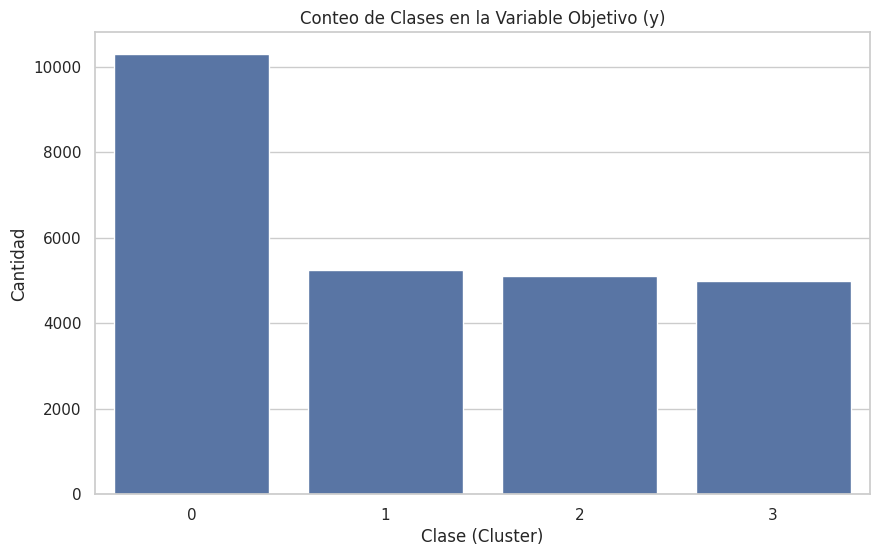


📊 Visualización 2: Mapas de Calor de Resultados


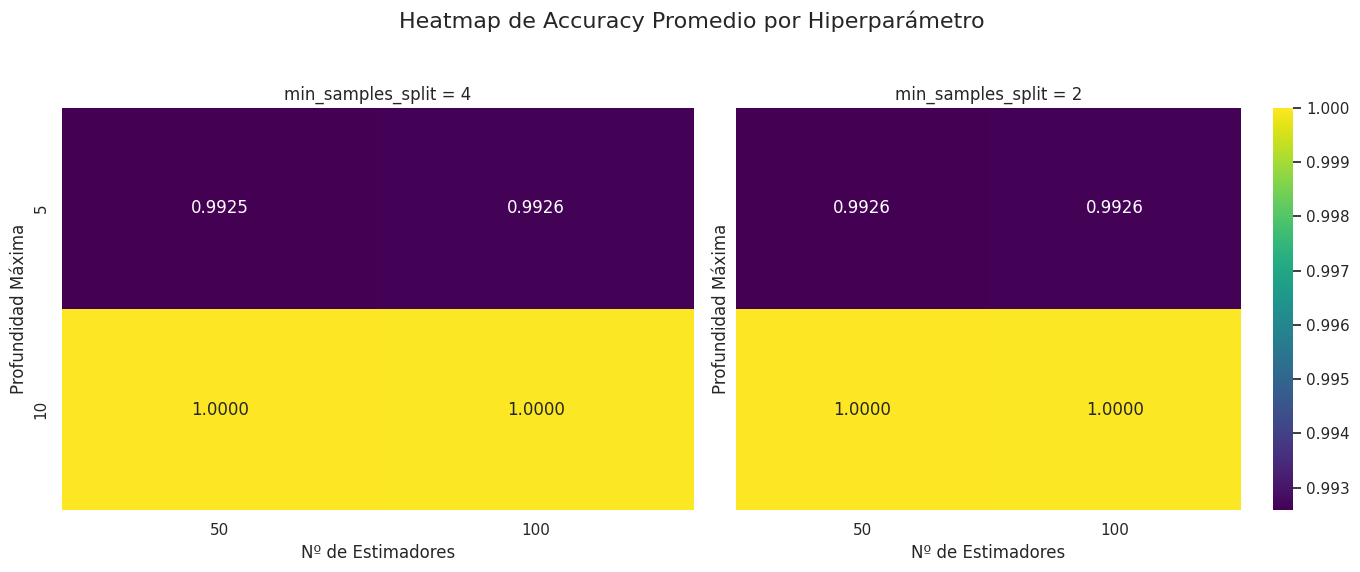


📊 Visualización 3: Importancia de las Características (Features)
Entrenando el mejor modelo con: 
{'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 4, 'mean_accuracy': 1.0, 'std_accuracy': 0.0, 'config': '50-10-4'}


/tmp/ipython-input-3556891453.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


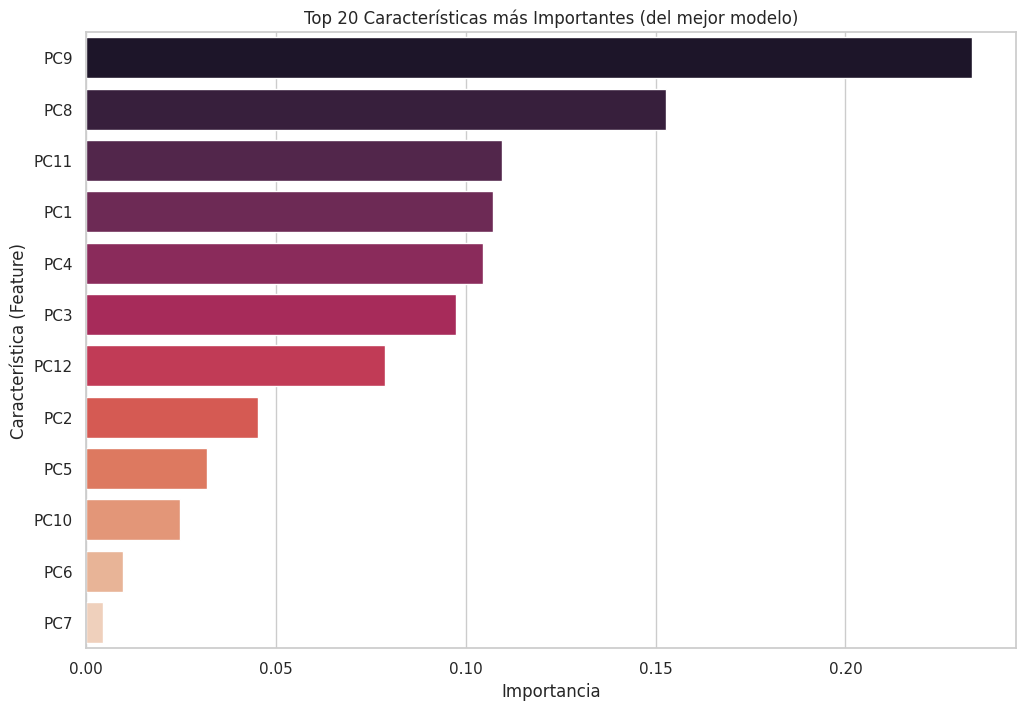

In [19]:

import seaborn as sns


sns.set(style="whitegrid")


X = pd.read_csv("TrainX_cluster.csv")
y = pd.read_csv("TrainY_cluster.csv").squeeze()

print("Visualización 1: Distribución de la variable objetivo (y)")
plt.figure(figsize=(10, 6))
sns.countplot(x=y)
plt.title('Conteo de Clases en la Variable Objetivo (y)')
plt.xlabel('Clase (Cluster)')
plt.ylabel('Cantidad')
plt.show()



print("\n📊 Visualización 2: Mapas de Calor de Resultados")

split_values = df_results['min_samples_split'].unique()

fig, axes = plt.subplots(1, len(split_values), figsize=(14, 6), sharey=True)

if len(split_values) == 1:
     axes = [axes]

for i, split_val in enumerate(split_values):

    df_subset = df_results[df_results['min_samples_split'] == split_val]


    df_pivot = df_subset.pivot(
        index='max_depth',
        columns='n_estimators',
        values='mean_accuracy'
    )


    sns.heatmap(
        df_pivot,
        annot=True,
        fmt=".4f",
        cmap="viridis",
        ax=axes[i],
        cbar=(i == len(split_values) - 1)
    )
    axes[i].set_title(f'min_samples_split = {split_val}')
    axes[i].set_xlabel('Nº de Estimadores')
    axes[i].set_ylabel('Profundidad Máxima')

fig.suptitle('Heatmap de Accuracy Promedio por Hiperparámetro', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



print("\nVisualización 3: Importancia de las Características (Features)")

best_params = df_results.iloc[0]
print(f"Entrenando el mejor modelo con: \n{best_params.to_dict()}")


best_model = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    random_state=42
)
best_model.fit(X, y)


importances = best_model.feature_importances_
feature_names = X.columns
df_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)


top_n = 20
plt.figure(figsize=(12, 8))
sns.barplot(
    x='importance',
    y='feature',
    data=df_importances.head(top_n),
    palette='rocket'
)
plt.title(f'Top {top_n} Características más Importantes (del mejor modelo)')
plt.xlabel('Importancia')
plt.ylabel('Característica (Feature)')
plt.show()

# Pipeline

1) sacar clusters

2) el cluister será ahora una nueva columna

3) agarrar datos, y sacas la columna target que será el cluster

4) aplicas cualquier algoritmo de clasificación, donde la variable Y es el cluster

este for no hacerlo con lusters sino con algoritmo de clasificacion



hacer el metodo de codo o de silueta para encontrar la mejor cantidad de siluetas